People messaged at Valve:
- Chris Carollo
- John McDonald
- Kristian Miller
- Mike Ambinder

In [1]:
import requests
import json
import pandas as pd
import numpy as np


# Pickles here

In [ ]:
#Time series is used for predicting a future value based on current values. Also, variables must be continuous.

In [2]:
# matches.to_pickle('matches.pkl')
matches = pd.read_pickle('matches.pkl')
# results = requests.get('https://api.opendota.com/api/matches/4778913838/performances')
# jsonified = results.json()

In [3]:
matches.sample(5)

,match_id,minute,dire_Anti-Mage,dire_Axe,dire_Bane,dire_Bloodseeker,dire_Crystal Maiden,dire_Drow Ranger,dire_Earthshaker,radiant_Abaddon,...,9mithril_hammer,9satanic,9staff_of_wizardry,9blades_of_attack,9monkey_king_bar,9platemail,9pipe,9dagon_2,9boots,radiant_win
49529,4889360849,18,0,0,0,0,0,0,0,0,...,2,0,0,1,0,0,0,0,1,1
59193,4899998031,46,0,0,0,0,0,0,0,0,...,2,0,1,1,0,1,0,0,1,0
82888,4931035786,52,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
14758,4810666092,35,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
124897,4984544598,40,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1


# Getting the rows to be team-centric
|  Column          | Description                                                                                                                                 |   |   |   |
|------------------|---------------------------------------------------------------------------------------------------------------------------------------------|---|---|---|
| match_id         | __Integer Value__. Match ID for the given match. Also referenced in downloadable replays.                                                       |   |   |   |
| minute           |  __Integer Value__. The minute of data of the current row.                                                                                      |   |   |   |
| dire_heroes      |  __Boolean Value__. Dire heroes that are currently alive in the match. A 1 signifies that the hero is currently alive for the dire team.        |   |   |   |
| radiant_heroes   |   __Boolean Value__. Radiant heroes that are currently alive in the match. A 1 signifies that the hero is currently alive for the radiant team. |   |   |   |
| player_last_hits |   __Integer Value__. Cumulative Sum of last hits the player has.                                                                                |   |   |   |
| player_denies    |  __Integer Value__. Cumulative Sum of denies the player has.                                                                                    |   |   |   |
| player_items     |  __Integer Value__. Cumulative Sum of the number of items the player has purchased.                                                             |   |   |   |
| player_gold      |  __Integer Value__. Cumulative Sum of the amount of gold a player has.                                                                          |   |   |   |
| player_kills     |  __Integer Value__. Number of kills the player has.                                                                                             |   |   |   |
| vision           |  __Integer Value__. Cumulative Sum of wards and sentries placed throughout the match.                                                           |   |   |   |
| __radiant_win__  |  __Boolean Value__. Target variable. 1 signifies the radiant team has won.   

## Time to get functional.

In [ ]:
from collections import defaultdict, Counter
from copy import deepcopy
#But first, a word from our heroes and our items
heroes = pd.read_csv('heroes.csv')
hero_id = heroes['hero_id'].tolist()
hero_name = heroes['name'].tolist()
name2local = dict(zip(heroes['name'].tolist(),heroes['localized_name'].tolist()))
hero_dict = dict(zip(hero_id,hero_name))

items = pd.read_csv('items.csv',header=None,squeeze = True)[1]
items_dict = {item:[] for item in items}
objectives = pd.read_csv('objectives.csv')['0.1']


def get_player_slot(json, player_index):
    return json['players'][player_index]['player_slot']

def get_hero_name(json,player_index):
    return hero_dict[json['players'][player_index]['hero_id']]

def get_win_status(json,player_index):
    return json['players'][player_index]['radiant_win']

def get_denies(json,player_index):
    return json['players'][player_index]['dn_t']

def get_last_hits(json, player_index):
    return json['players'][player_index]['lh_t']

def get_gold(json, player_index):
    return json['players'][player_index]['gold_t']

def get_xp(json, player_index):
    return json['players'][player_index]['xp_t']

def get_kill_nums(json,player_index):
    '''
    Given a json and player_index, return the number cumulative sum of kills a player receives in a match.
    Each index of the list will correspond to a minute in the game.
    '''
    
    times = json['players'][player_index]['times']
    kills_nums = [0]*len(times)
    for kill in json['players'][player_index]['kills_log']:
        kills_nums[int(kill['time']/60)]+=1
    return np.cumsum(kills_nums)

def get_players_objectives(json,player_index):
    '''
    Given the json object and player_index to reference, return a list of lists.
    Each index of the outer list will correspond to a minute.
    The inner list at each of these indeces will contain lists of objectives that were taken at that minute.
    '''
    objectives_by_minute = defaultdict(lambda: [])
    objectives_list = json['objectives']
    time_list = json['players'][player_index]['times']
    for time in time_list:
        objectives_by_minute[int(time/60)] = []
    for objective in objectives_list:
        if ('player_slot' in objective)&('key' in objective):
            if objective['player_slot']==get_player_slot(json,player_index):
                objectives_by_minute[int(objective['time']/60)].append(objective['key'])
    return list(objectives_by_minute.values())

# Data leak point:
# This function does not account for denying towers nor courier kills nor roshan. Only accounts for towers.

def get_purchase_log(json,player_index):
    '''
    Given the json object and player_index to reference, return a list of lists.
    Each index of the outer list will correspond to a minute.
    The inner list at each of these indeces will contain a list of items purchased at that minute.
    '''
    purchase_by_minute = defaultdict(list)
    purchases_list = json['players'][player_index]['purchase_log']
    time_list = json['players'][player_index]['times']
    for time in time_list:
        purchase_by_minute[int(time/60)]=[]
    for purchase in purchases_list:
        if(purchase['time']<0):
            purchase['time']=1
        purchase_by_minute[int(purchase['time']/60)].append(purchase['key'])
    return list(purchase_by_minute.values())

def get_kill_log(json,player_index):
    '''
    Given the json object and player_index to reference, return a list of lists.
    Each index of the outer list will correspond to a minute.
    The inner list at each of these indeces will contain a list of kills at that minute.
    '''
    kills_by_minute = defaultdict(list)
    kills_list = json['players'][player_index]['kills_log']
    time_list = json['players'][player_index]['times']
    for time in time_list:
        kills_by_minute[int(time/60)]=[]
    for kill in kills_list:
        kills_by_minute[int(kill['time']/60)].append(kill['key'])
    return list(kills_by_minute.values())

def get_vision_log(json,player_index):
    '''
    Given the json object and player_index to reference, return a list of lists.
    Each index of the outer list will correspond to a minute.
    The inner list at each of these indeces will contain a list of dictionaries, which represent a ward and its placement
    at that particular minute.
    '''
    vision_by_minute = defaultdict(lambda: [])
    vision_list = json['players'][player_index]['obs_log']
    vision_list.extend(json['players'][player_index]['sen_log'])
    time_list = json['players'][player_index]['times']
    for time in time_list:
        vision_by_minute[int(time/60)]=[]
    if vision_list==None:
        return vision_by_minute
    else:
        for vision in vision_list:
            viz = {'time':vision['time'], 'type': vision['type'],
                   'x':vision['x'], 'y':vision['y'],'z':vision['z']}
            if vision['time']<0:
                vision['time']=0
            vision_by_minute[int(vision['time']/60)].append(viz)  
    return list(vision_by_minute.values())

from functools import reduce

########################
#                      #
# Frame Functions Here!#
#                      #
########################

def purchase_to_frame(json,player_index): #HELPER FUNCTION FOR HEROES_TO_FRAME
    '''
    Given the json object and player index to reference, return a dataframe.
    The header is the items, and the values are the cumulative sum of items bought at each minute.
    '''
    

    purchases = get_purchase_log(json,player_index)
    counter = Counter()
    row_cumsums = []
    for row in purchases:
        counter.update(row)
        row_cumsums.append(counter.copy())
    all_keys = dict.fromkeys(items, 0)
    for i, row in enumerate(row_cumsums):
        row.update(all_keys)
        row_cumsums[i] = row
    df = pd.DataFrame(row_cumsums)
    header = df.columns
    new_head = [(str(player_index))+head for head in header]
    df.columns = new_head
    return df

    #Data Loss: This function does not take into account when an item is sold or used for another item.
    
def kills_to_frame(json,player_index): #HELPER FUNCTION FOR HEROES_TO_FRAME!!
    '''
    Given a json object and player index, return that player's dataframe of kills.
    A 1 in each row for a column signifies that hero was killed. 0 signifies no death occurred.
    '''
    kills = get_kill_log(json,player_index)
    hero_counter = Counter()
    row_cumsums = []
    for row in kills:
        hero_counter.update(row)
        row_cumsums.append(hero_counter.copy())
    hero_keys = dict.fromkeys(heroes['name'].tolist(),0) #input for fromkeys is distinct heroes
    for i, row in enumerate(row_cumsums):
        row.update(hero_keys)
        row_cumsums[i] = row
    df = pd.DataFrame(row_cumsums)
    return df.diff().fillna(0).astype('int32')  

def objectives_to_frame(json):
    '''
    Given a json object, return both teams' lists of objectives taken.
    A 1 in each row for a column signifies that the objective has been taken. 0 Signifies it has not.
    '''
    list_of_df = []
    for player in range(0,10):
        objectives_list = get_players_objectives(json,player)
        objective_counter = Counter()
        row_cumsums = []
        for row in objectives_list:
            objective_counter.update(row)
            row_cumsums.append(objective_counter.copy())
        objective_keys = dict.fromkeys(objectives,0)
        for index, row in enumerate(row_cumsums):
            row.update(objective_keys)
            row_cumsums[index] = row
        list_of_df.append(pd.DataFrame(row_cumsums))
    return reduce(lambda x, y: x.add(y,fill_value=0),list_of_df).fillna(0).astype('int32')

def vision_to_frame(json):
    '''
    Given the json object, return a dataframe where the index is representative of the time a vision
    object was placed. Columns: radiant_obs, radiant_sen, dire_obs, dire_sen.
    '''
    time = len(json['players'][0]['times']) # get the number of minutes a match lasts
    radiant_obs = [0]*time
    radiant_sen = [0]*time
    dire_obs = [0]*time
    dire_sen = [0]*time
    
    for player in range(10): # loop through all the players
        current_vis_log = get_vision_log(json,player)
        for index,minute in enumerate(current_vis_log): # loop through each minute of vis log
            for item in minute: # loop through possible vision applied
                if(item['time']<0):
                    item['time']=0 # Assign any early wards to have a value of zero for ease
                if((item['type']=='obs_log')&(player<5)):
                    radiant_obs[index]+=1
                elif((item['type']=='sen_log')&(player<5)):
                    radiant_sen[index]+=1
                elif((item['type']=='obs_log')&(player>=5)):
                    dire_obs[index]+=1
                elif((item['type']=='sen_log')&(player>=5)):
                    dire_obs[index]+=1
    vision ={'radiant_obs':radiant_obs, 'radiant_sen':radiant_sen,
            'dire_obs':dire_obs, 'dire_sen':dire_sen}
    return pd.DataFrame(vision)
    
    # Data Loss: This does not account for if vision is destroyed prematurely.
    

def players_to_frame(json):
    '''
    Given a json object and player_index, combine functions to create a dataframe object.
    '''
    frames = []
    rows = len(json['players'][0]['times'])
    keys = ['hero_name','last_hits','denies','gold','xp','kills_num']
    for player_index in range(10):
        indexed_keys = [str(player_index)+key for key in keys]
        indexed_keys
        data = {indexed_keys[1]: get_last_hits(json,player_index),
               indexed_keys[2]: get_denies(json,player_index),
               indexed_keys[3]: get_gold(json,player_index),
               indexed_keys[4]: get_xp(json,player_index),
               indexed_keys[5]: get_kill_nums(json,player_index)
               }
        purchases = purchase_to_frame(json,player_index)
        frames.append(pd.DataFrame(data).join(purchases))
    return pd.concat(frames,axis=1)  

def heroes_to_frame(json):
    '''
    Given the json object, return a dataframe containing the heroes that were in the match.
    A 1 in value signifies the hero was alive during that minute. A 0 signifies it was dead for some time
    during that minute.
    '''
    
    radiant_team = []
    dire_team = []
    for player in range(0,10):
        if player<5:
            radiant_team.append(get_hero_name(json,player))
        else:
            dire_team.append(get_hero_name(json,player))
    hero_names = heroes['name'].tolist()
    times = len(json['players'][0]['times'])
    base_dict = dict(zip(heroes['name'].tolist(),[[0]*times]*len(hero_names)))
    radiant_frame = pd.DataFrame(base_dict)
    dire_frame = pd.DataFrame(base_dict)
    
    for radiant in radiant_team:
        radiant_frame[radiant] = 1
    for dire in dire_team:
        dire_frame[dire] = 1
    
    radiant_deaths = kills_to_frame(json,5)
    for player in range(6,10):
        radiant_deaths.add(kills_to_frame(json,player))
    dire_deaths = kills_to_frame(json,0)
    for player in range(1,5):
        dire_deaths.add(kills_to_frame(json,player))
    
    living_radiant = radiant_frame.subtract(radiant_deaths)
    living_dire = dire_frame.subtract(dire_deaths)
    
    radiant_columns = living_radiant.columns
    dire_columns = living_dire.columns
    
    new_rad_col = ['radiant_'+(name2local[hero]) for hero in hero_names]
    new_dire_col = ['dire_'+(name2local[hero]) for hero in hero_names]
    
    living_radiant.columns = new_rad_col
    living_dire.columns = new_dire_col
    
    return pd.concat([living_radiant,living_dire],axis=1, join='inner')

#Think about using hierarchical columns for next time.

![alt text](https://media1.tenor.com/images/a71c94c3aa7ad66a5051f81f48d14dd2/tenor.gif?itemid=12813012)


In [ ]:
def match_frame(json):
    '''
    Bringing it all together. For a json, return a dataframe with all purchase, hero living information, and objectives
    taken.
    '''
    df = pd.concat([heroes_to_frame(json), objectives_to_frame(json),vision_to_frame(json),
                      players_to_frame(json)],axis=1)
    df['radiant_win'] = json['players'][0]['radiant_win']
    df['match_id'] = json['match_id']
    return df

In [ ]:
# import csv
# match_id = []
# with open('match_id_more.csv','r') as file:
#     file_reader = csv.reader(file)
#     for row in file_reader:
#         match_id.extend(row)

In [ ]:
# matches_list = []
# error_list = []
# counter = 0
# for match in match_id:
#     response = requests.get('https://api.opendota.com/api/matches/'+str(match)+'/performances')
#     try:
#         matches_list.append(match_frame(response.json()))
#         print(str(counter)+ ". Finished processing match "+ str(match))
#         counter+=1
#     except:
#         print("ERROR@ MATCH: "+str(match))
#         error_list.append(match)
#         counter+=1
# matches = pd.concat(matches_list)
# matches.reset_index(inplace=True)
# matches.rename(columns = {'index':'minute'},inplace=True)
# matches.drop([x for x in range(0,10)],axis=1, inplace=True)
# matches.drop([str(x) for x in range(1,10)], axis=1, inplace=True)
# matches.drop(['npc_dota_goodguys_fort'], axis=1, inplace=True)
# matches.drop(['npc_dota_badguys_fort'], axis=1, inplace=True)
# matches['radiant_win']=matches['radiant_win'].astype(int)
# column = matches.columns.tolist()
# column = column[-1:] + column[:-1]
# matches = matches[column]

In [ ]:
# For cleaning matches

In [ ]:
# errors = pd.DataFrame(error_list,columns=["errors"])
# errors.to_csv('error_list.csv',index=False)
# matches.to_pickle('matches.pkl')

# XGBoost approach
https://xgboost.readthedocs.io/en/latest/python/python_intro.html

In [4]:
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Round 0
             precision    recall  f1-score   support

          0       0.83      0.76      0.79      7818
          1       0.78      0.85      0.82      7955

avg / total       0.81      0.81      0.81     15773

Normalized confusion matrix
[[0.75850601 0.24149399]
 [0.14758014 0.85241986]]
Round 1
             precision    recall  f1-score   support

          0       0.82      0.75      0.78      7774
          1       0.77      0.84      0.81      7999

avg / total       0.80      0.79      0.79     15773

Normalized confusion matrix
[[0.74556213 0.25443787]
 [0.15901988 0.84098012]]
Round 2
             precision    recall  f1-score   support

          0       0.83      0.75      0.79      7808
          1       0.78      0.85      0.81      7965

avg / total       0.80      0.80      0.80     15773

Normalized confusion matrix
[[0.75076844 0.24923156]
 [0.15040804 0.84959196]]
Round 3
             precision    recall  f1-score   support

          0       0.83      0.75

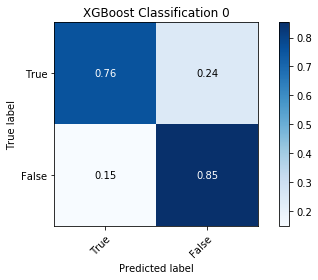

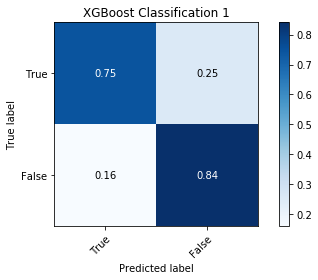

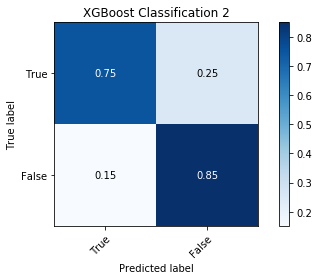

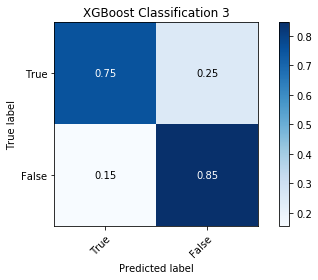

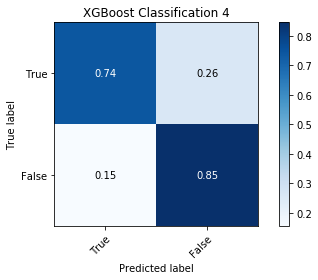

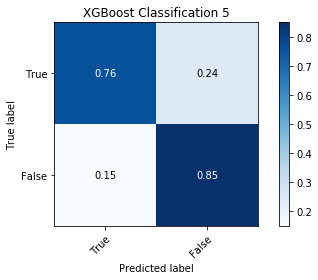

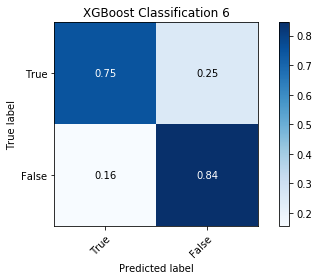

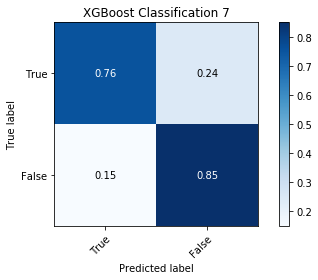

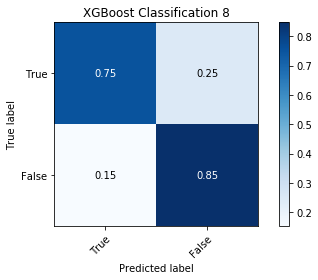

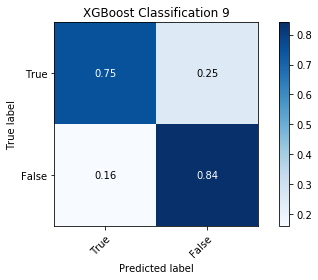

In [5]:
data = np.array(matches)
kfold = KFold(10, shuffle=True)

run = 0
for train, test in kfold.split(data):
    print('Round '+str(run))
    X_train = data[train,:-1]
    X_test = data[test,:-1]
    y_train = data[train,-1]
    y_test = data[test,-1]
    param ={'eta':.1, 'max_depth' : 10, 'min_child_weight' : 10,
           'n_jobs':-1, 'predictor': 'gpu_predictor'}
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    model = xgb.train(param,dtrain,10)
    
    y_prediction = model.predict(dtest)
    y_prediction_ints = [0 if x < 0.5 else 1 for x in y_prediction]
    
    print(classification_report(y_test,y_prediction_ints))
    plot_confusion_matrix(y_test, y_prediction_ints, [True,False],normalize = True,title = "XGBoost Classification "+str(run))
    run+=1


## Highest Accuracy was 80.5%
Let's look at a different method now. Let's try 
# __random forest__.

In [ ]:
from sklearn.ensemble import RandomForestClassifier as rfc


X = data[:,:-1]
y = data[:,-1]



X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=.2)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size =.2)

classifier = rfc(n_estimators =10, max_depth = 10, min_samples_split = 2, min_samples_leaf =1,
                n_jobs=-1)
classifier.fit(X_train,y_train)
y_prediction = classifier.predict(X_val)

print(classification_report(y_val,y_prediction))
plot_confusion_matrix(y_val, y_prediction, [True,False],normalize = True,title = "Random Forest Classification ")


In [ ]:
columns = matches.columns
importance = classifier.feature_importances_

feature_table = pd.DataFrame(importance,index=columns[:-1],columns=['value'])
feature_table.sort_values(['value'],ascending=False).head()

In [ ]:
y_preds = classifier.predict_proba(X_val)
preds = y_preds[:,1]
fpr, tpr, _ = metrics.roc_curve(y_val,preds)
auc_score = metrics.auc(fpr,tpr)
plt.clf()
plt.title('ROC/AUC RFC')
plt.plot(fpr,tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## Well. Even with the error,
### It looks like random forest is no match for xgboost in this scenario.
Let's take a look back at xgboost and see if we can make better hyperparamters.

In [ ]:
kfold = KFold(5, shuffle=True)

run = 0
for train, test in kfold.split(data):
    print('Round '+str(run))
    X_train = data[train,:-1]
    X_test = data[test,:-1]
    y_train = data[train,-1]
    y_test = data[test,-1]
    param ={'eta':.1, 'max_depth' : 18, 'min_child_weight' : 60,
           'n_jobs':-1, 'predictor': 'gpu_predictor'}
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    model = xgb.train(param,dtrain,10)
    
    y_prediction = model.predict(dtest)
    y_prediction_ints = [0 if x < 0.5 else 1 for x in y_prediction]
    
    print(classification_report(y_test,y_prediction_ints))
    plot_confusion_matrix(y_test, y_prediction_ints, [True,False],normalize = True,title = "XGBoost Classification "+str(run))
    run+=1


In [ ]:
matches_0 = matches[matches['minute']==0]

In [ ]:
kfold = KFold(10, shuffle=True)

data = np.array(matches)

run = 0
for train, test in kfold.split(data):
    print('Round '+str(run))
    X_train = data[train,:-1]
    X_test = data[test,:-1]
    y_train = data[train,-1]
    y_test = data[test,-1]
    param ={'eta':.1, 'max_depth' : 18, 'min_child_weight' : 10,
           'n_jobs':-1, 'predictor': 'gpu_predictor'}
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    model = xgb.train(param,dtrain,10)
    
    y_prediction = model.predict(dtest)
    y_prediction_ints = [0 if x < 0.5 else 1 for x in y_prediction]
    
    print(classification_report(y_test,y_prediction_ints))
    plot_confusion_matrix(y_test, y_prediction_ints, [True,False],normalize = True,title = "XGBoost Classification "+str(run))
    run+=1


In [ ]:
feature_importance = model.get_fscore()
keys = feature_importance.keys()
vals = feature_importance.values()

feature_frame = pd.DataFrame(vals, index = keys, columns = ['values'])
feature_frame.sort_values(['values'],ascending=False).iloc[37:40,:]

In [ ]:
y_preds = model.predict(dtest)
preds = y_preds
fpr, tpr, _ = metrics.roc_curve(y_test,preds)
auc_score = metrics.auc(fpr,tpr)
plt.clf()
plt.title('ROC/AUC XGB')
plt.plot(fpr,tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

Let's try and divide up the matches into three time segments. Early, mid, and late game.
- Early game is usually accepted as 0-15 minutes
- Mid game is reserved from 15 to 30 minutes
- Late game is anything after that.


In [9]:
# X = matches.iloc[:,:-1]
# y = matches.iloc[:,-1]

# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

# param ={'eta':.1, 'max_depth' : 18, 'min_child_weight' : 10,
#        'n_jobs':-1, 'predictor': 'gpu_predictor'}

# dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
# dtest = xgb.DMatrix(X_test.values)
# model = xgb.train(param,dtrain,10)

# y_prediction = model.predict(dtest)
# y_prediction_ints = [0 if x < 0.5 else 1 for x in y_prediction]

# print(classification_report(y_test,y_prediction_ints))
# plot_confusion_matrix(y_test, y_prediction_ints, [True,False],normalize = True,title = "XGBoost Classification ")

# Prediction from the 20 minute mark only:
Model works okay with the whole dataset, let's see how well it does with only seeing up to 20 minutes.

In [7]:
matches_20_id = matches['match_id'].loc[matches['minute']==20]
matches_20 = matches.loc[matches['match_id'].isin( matches_20_id)]
matches_20.drop('match_id',axis=1, inplace=True)
matches_20 = matches_20[matches_20['minute']<=20].copy()

C:\Users\Animaznman\Anaconda3\lib\site-packages\pandas\core\frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Round 0
             precision    recall  f1-score   support

          0       0.94      0.91      0.93      4255
          1       0.92      0.94      0.93      4479

avg / total       0.93      0.93      0.93      8734

Normalized confusion matrix
[[0.91398355 0.08601645]
 [0.05581603 0.94418397]]
Round 1
             precision    recall  f1-score   support

          0       0.95      0.91      0.93      4264
          1       0.92      0.96      0.94      4470

avg / total       0.93      0.93      0.93      8734

Normalized confusion matrix
[[0.90970919 0.09029081]
 [0.04272931 0.95727069]]
Round 2
             precision    recall  f1-score   support

          0       0.95      0.93      0.94      4214
          1       0.94      0.95      0.94      4520

avg / total       0.94      0.94      0.94      8734

Normalized confusion matrix
[[0.92952065 0.07047935]
 [0.04955752 0.95044248]]
Round 3
             precision    recall  f1-score   support

          0       0.95      0.93

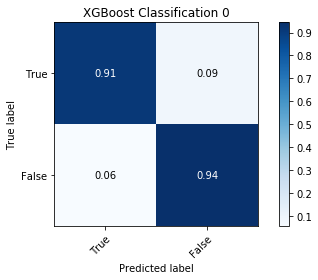

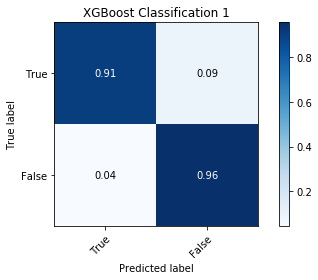

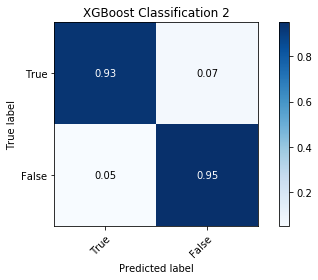

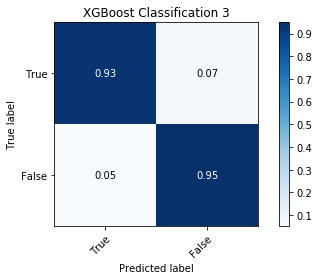

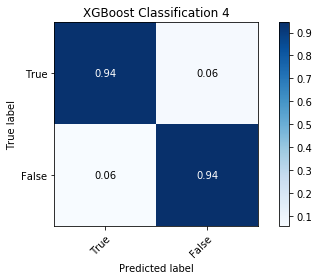

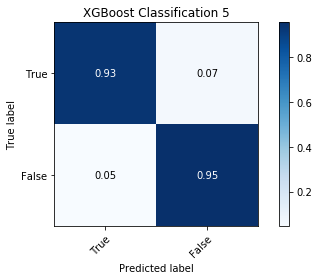

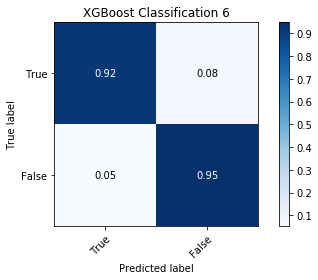

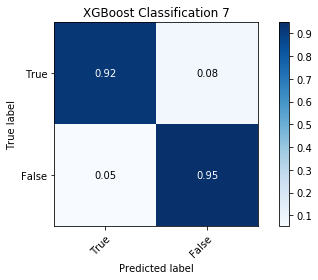

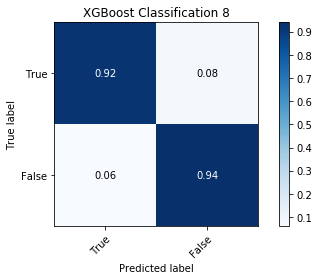

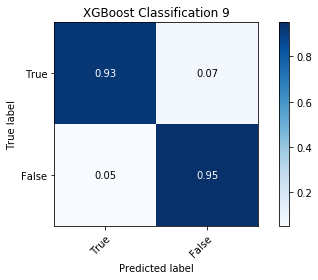

In [8]:
kfold = KFold(10, shuffle=True)

data = np.array(matches_20)

run = 0
for train, test in kfold.split(data):
    print('Round '+str(run))
    X_train = data[train,:-1]
    X_test = data[test,:-1]
    y_train = data[train,-1]
    y_test = data[test,-1]
    param ={'eta':.1, 'max_depth' : 18, 'min_child_weight' : 10,
           'n_jobs':-1, 'predictor': 'gpu_predictor'}
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    model = xgb.train(param,dtrain,10)
    
    y_prediction = model.predict(dtest)
    y_prediction_ints = [0 if x < 0.5 else 1 for x in y_prediction]
    
    print(classification_report(y_test,y_prediction_ints))
    plot_confusion_matrix(y_test, y_prediction_ints, [True,False],normalize = True,title = "XGBoost Classification "+str(run))
    run+=1


             precision    recall  f1-score   support

          0       0.94      0.92      0.93      8510
          1       0.93      0.94      0.93      8958

avg / total       0.93      0.93      0.93     17468

Normalized confusion matrix
[[0.92338425 0.07661575]
 [0.06083947 0.93916053]]


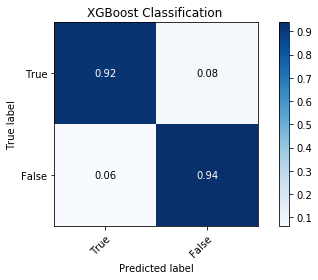

In [10]:
X = matches_20.iloc[:,:-1]
y = matches_20.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

param ={'eta':.1, 'max_depth' : 18, 'min_child_weight' : 10,
       'n_jobs':-1, 'predictor': 'gpu_predictor'}

dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
dtest = xgb.DMatrix(X_test.values)
model = xgb.train(param,dtrain,10)

y_prediction = model.predict(dtest)
y_prediction_ints = [0 if x < 0.5 else 1 for x in y_prediction]

print(classification_report(y_test,y_prediction_ints))
plot_confusion_matrix(y_test, y_prediction_ints, [True,False],normalize = True,title = "XGBoost Classification ")

# Around 93% accuracy!

Now for some comparison with Dota Plus, I'll append the probabilities to the dataframe and see what the outcome and % wins are for both my model and dota plus.

In [29]:
top_20 = X_test.head(20).index.tolist()
match_20_ids = matches['match_id'].iloc[top_20]
match_20_ids.tolist()

[4951817046,
 4867766066,
 4888732113,
 4931419285,
 5012656136,
 4996253086,
 4982620031,
 5011319564,
 4792472025,
 4915802544,
 4957086148,
 4810351350,
 4910114716,
 5003653679,
 4875571289,
 4853148298,
 4859002568,
 4835349235,
 4956394830,
 4959632935]

In [28]:
y_prediction[:20].tolist()

[0.6592558026313782,
 0.5764157176017761,
 0.5141096711158752,
 0.44689667224884033,
 0.30625563859939575,
 0.5621721148490906,
 0.46809759736061096,
 0.46229708194732666,
 0.6044390201568604,
 0.35111334919929504,
 0.3750510513782501,
 0.22402778267860413,
 0.47943270206451416,
 0.5774372220039368,
 0.16841751337051392,
 0.26780131459236145,
 0.7050307989120483,
 0.32459938526153564,
 0.3010585606098175,
 0.7903012037277222]

In [35]:
predicted = X_test.copy()
predicted['prediction'] = y_prediction

In [42]:
matches20 = predicted['prediction'][predicted['minute']==20].head(20).index.tolist()

In [49]:
matches.iloc[10003]

match_id          4799211995
minute                    20
dire_Anti-Mage             0
dire_Axe                   0
dire_Bane                  0
                     ...    
9platemail                 0
9pipe                      0
9dagon_2                   0
9boots                     1
radiant_win                0
Name: 10003, Length: 1955, dtype: int64

In [51]:
# predicted['radiant_win'] = y_test
predicted['radiant_win'][predicted['minute']==20].head(20).tolist()

[1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0]